In [398]:
import sys 
import numpy as np # linear algebra
from scipy.stats import randint
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import matplotlib.pyplot as plt # this is used for the plot the graph 
import seaborn as sns # used for plot interactive graph. 
from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score

## for Deep-learing:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout


import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler



In [399]:
import tensorflow as tf

# Ref: https://www.tensorflow.org/guide/gpu
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


In [400]:
df = pd.read_csv('data/base_data_8Y.csv')
df = df.dropna().copy()
#df['target'] = df['spy_oc_ret'].shift(-1)
#df = df.dropna()

df.index = df['datecol']

df['target'] = df['spy_oc_ret'].shift(-1)
df = df.dropna()

In [401]:


X = df[df.columns[~df.columns.isin(
    ['datecol', 'target','trade_date','target_1','target_2','target_3'])]]
y = np.where(df['target']>0.5,1,0)
y = np.where(df['target']<-0.5,2,y)


In [402]:
tmp = df[df.columns[(~df.columns.str.contains('close|open'))]]
X = tmp[tmp.columns[~tmp.columns.isin(
    ['datecol', 'target','trade_date','target_1','target_2','target_3'])]].copy()


In [403]:

def transform_ret_columns(ret):
    ret_val = 0
    if ret < -0.5:
        ret_val = 0
    elif ret <= 0:
        ret_val = 1
    elif ret > 0.5:
        ret_val = 3
    elif ret > 0:
        ret_val = 2
    return (ret_val)

y=df['target'].apply(lambda row: transform_ret_columns(row))



In [404]:
ret_columns = list(df.columns[(df.columns.str.contains('_ret'))])

scale_cols = ['spy_volume',
 'spy_volatility_atr',
 'spy_trend_ichimoku_conv',
 'spy_trend_ichimoku_base',
 'spy_trend_ichimoku_a',
 'spy_trend_ichimoku_b',
 'spy_trend_cci',
 'spy_momentum_rsi',
 'spy_trend_macd',
 'spy_trend_macd_signal',
 'spy_momentum_ppo',
 'spy_momentum_ppo_signal',
 'Real_PCE',
 'Real_PCE_YoY',
 'Initial_Claims',
 'Initial_Claims_YoY',
 'USD_Daily_Return',
 'Inflation Rate',
 '10yr minus 2yr yield',
 'Inversion Signal',
 'US_Personal_Savings_Rate',
 'US_Real_Disposable_Income',
 'M2_and_Components',
 'Job_Openings_Total_Nonfarm',
 'St_Louis_Fed_Fin_Stress_Index',
 'Chicago_Fed_Fin_Conditions_Index']

In [405]:
# TRANSFORMATION

for k in df.columns[(df.columns.str.contains('_ret'))]:
    #print(k)
    
    X[k] = X[k].apply(lambda row: transform_ret_columns(row))
    
#X[df.columns[(df.columns.str.contains('_ret'))]]


X['Chicago_Fed_Fin_Conditions_Index'] = X['Chicago_Fed_Fin_Conditions_Index'] ** 2
X['spy_volume'] = np.log2(X['spy_volume'])
X['spy_volatility_atr'] = np.log2(X['spy_volatility_atr'])
X['spy_trend_ichimoku_conv'] = np.log2(X['spy_trend_ichimoku_conv'])
X['spy_trend_ichimoku_base'] = np.log2(X['spy_trend_ichimoku_base'])
X['spy_trend_ichimoku_a'] = np.log2(X['spy_trend_ichimoku_a'])
X['spy_trend_ichimoku_b'] = np.log2(X['spy_trend_ichimoku_b'])


In [406]:
# SCALING

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

#ct = ColumnTransformer([
#        ('somename',StandardScaler(), scale_cols)
#    ], remainder='passthrough')

scaler = StandardScaler()


X[scale_cols] = scaler.fit_transform(X[scale_cols].values)

X_scale_df = pd.DataFrame(X,columns=X.columns)


In [407]:
X_scale_df

,spy_oc_ret,spy_pco_ret,spy_volume,spy_volatility_atr,spy_trend_ichimoku_conv,spy_trend_ichimoku_base,spy_trend_ichimoku_a,spy_trend_ichimoku_b,spy_trend_cci,spy_momentum_rsi,...,month3,month4,month5,month6,month7,month8,month9,month10,month11,month12
datecol,,,,,,,,,,,,,,,,,,,,,
2015-01-30,0,0,1.98,-0.05,-1.32,-1.28,-1.30,-1.22,-1.20,-1.20,...,0,0,0,0,0,0,0,0,0,0
2015-02-02,3,2,1.81,0.01,-1.33,-1.29,-1.31,-1.22,-1.00,-0.67,...,0,0,0,0,0,0,0,0,0,0
2015-02-03,3,3,1.29,-0.01,-1.33,-1.29,-1.31,-1.22,0.34,-0.13,...,0,0,0,0,0,0,0,0,0,0
2015-02-04,2,1,1.34,-0.08,-1.33,-1.29,-1.31,-1.22,0.36,-0.29,...,0,0,0,0,0,0,0,0,0,0
2015-02-05,3,2,0.67,-0.13,-1.33,-1.29,-1.31,-1.22,0.76,0.07,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-01,1,2,-0.17,1.17,1.29,1.19,1.24,1.12,0.84,0.72,...,0,0,0,0,0,0,0,0,0,1
2022-12-02,3,0,-0.24,1.15,1.29,1.19,1.24,1.12,0.72,0.67,...,0,0,0,0,0,0,0,0,0,1
2022-12-05,0,0,-0.30,1.20,1.29,1.19,1.24,1.12,0.28,0.01,...,0,0,0,0,0,0,0,0,0,1


In [408]:
df1 = df.copy()

df = X_scale_df.copy()

In [409]:
step_size = 30
mldf = pd.DataFrame()
df = df.reset_index(drop=True)

for i, row in df.iterrows():
    #print(row['date'])
    if i > step_size:
        tmp1 = df.iloc[i,:].copy().reset_index(drop = True)
        test = pd.DataFrame(tmp1)
        test_T = test.T.reset_index(drop = True)
        test_T.columns = df.columns


        for k in range(1,step_size):  # from 0 to 2
            tmp = df.iloc[i-k,:].copy().reset_index(drop = True)    # from 3-0, 3-1, 3-2
            test1 = pd.DataFrame(tmp)
            test1_T = test1.T.reset_index(drop = True)
            test1_T.columns = df.columns
            suffix_col = '_' + str(step_size-k)
            test1_T = test1_T.add_suffix(suffix_col)
            test_T = pd.concat([test_T,test1_T],axis=1)
        
        mldf = pd.concat([mldf,test_T],axis = 0)

In [410]:
mldf = mldf.dropna()

In [411]:
mldf

,spy_oc_ret,spy_pco_ret,spy_volume,spy_volatility_atr,spy_trend_ichimoku_conv,spy_trend_ichimoku_base,spy_trend_ichimoku_a,spy_trend_ichimoku_b,spy_trend_cci,spy_momentum_rsi,...,month3_1,month4_1,month5_1,month6_1,month7_1,month8_1,month9_1,month10_1,month11_1,month12_1
0,2.00,1.00,0.64,-0.77,-1.23,-1.20,-1.21,-1.23,-0.76,-0.43,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
0,3.00,1.00,2.33,-0.57,-1.22,-1.20,-1.21,-1.23,-0.21,0.12,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
0,1.00,1.00,0.83,-0.63,-1.22,-1.20,-1.21,-1.23,-0.15,-0.12,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
0,2.00,2.00,1.25,-0.68,-1.22,-1.20,-1.21,-1.23,0.10,0.07,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
0,1.00,2.00,-0.43,-0.76,-1.22,-1.20,-1.21,-1.23,0.12,-0.04,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,1.00,2.00,-0.17,1.17,1.29,1.19,1.24,1.12,0.84,0.72,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
0,3.00,0.00,-0.24,1.15,1.29,1.19,1.24,1.12,0.72,0.67,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
0,0.00,0.00,-0.30,1.20,1.29,1.19,1.24,1.12,0.28,0.01,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
0,0.00,1.00,-0.05,1.24,1.28,1.19,1.24,1.12,-0.45,-0.44,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00


In [412]:
y = y[step_size+1:]

In [413]:

np.shape(y)



(1933,)

In [414]:
from lazypredict.Supervised import LazyClassifier, LazyRegressor
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
# Dataframe manipulation
import pandas as pd
# Linear algebra
import numpy as np

In [415]:
X_train, X_test, y_train, y_test = train_test_split(np.array(mldf), np.array(y),test_size=.3,random_state =123)

clf = LazyClassifier(verbose=0,ignore_warnings=False, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)

print(models)

  3%|██                                                        | 1/29 [00:06<03:06,  6.66s/it]

ROC AUC couldn't be calculated for AdaBoostClassifier
multi_class must be in ('ovo', 'ovr')


  7%|████                                                      | 2/29 [00:13<02:56,  6.55s/it]

ROC AUC couldn't be calculated for BaggingClassifier
multi_class must be in ('ovo', 'ovr')


 10%|██████                                                    | 3/29 [00:13<01:36,  3.70s/it]

ROC AUC couldn't be calculated for BernoulliNB
multi_class must be in ('ovo', 'ovr')


 14%|████████                                                  | 4/29 [00:37<04:56, 11.87s/it]

ROC AUC couldn't be calculated for CalibratedClassifierCV
multi_class must be in ('ovo', 'ovr')
CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)


 21%|████████████                                              | 6/29 [00:39<02:04,  5.43s/it]

ROC AUC couldn't be calculated for DecisionTreeClassifier
multi_class must be in ('ovo', 'ovr')
ROC AUC couldn't be calculated for DummyClassifier


 24%|██████████████                                            | 7/29 [00:39<01:21,  3.72s/it]

multi_class must be in ('ovo', 'ovr')


 28%|████████████████                                          | 8/29 [00:39<00:54,  2.61s/it]

ROC AUC couldn't be calculated for ExtraTreeClassifier
multi_class must be in ('ovo', 'ovr')


 31%|██████████████████                                        | 9/29 [00:40<00:44,  2.23s/it]

ROC AUC couldn't be calculated for ExtraTreesClassifier
multi_class must be in ('ovo', 'ovr')


 34%|███████████████████▋                                     | 10/29 [00:41<00:31,  1.64s/it]

ROC AUC couldn't be calculated for GaussianNB
multi_class must be in ('ovo', 'ovr')


 38%|█████████████████████▌                                   | 11/29 [00:41<00:22,  1.24s/it]

ROC AUC couldn't be calculated for KNeighborsClassifier
multi_class must be in ('ovo', 'ovr')


 41%|███████████████████████▌                                 | 12/29 [00:41<00:16,  1.02it/s]

ROC AUC couldn't be calculated for LabelPropagation
multi_class must be in ('ovo', 'ovr')


 45%|█████████████████████████▌                               | 13/29 [00:42<00:12,  1.23it/s]

ROC AUC couldn't be calculated for LabelSpreading
multi_class must be in ('ovo', 'ovr')


 48%|███████████████████████████▌                             | 14/29 [00:43<00:14,  1.06it/s]

ROC AUC couldn't be calculated for LinearDiscriminantAnalysis
multi_class must be in ('ovo', 'ovr')


 52%|█████████████████████████████▍                           | 15/29 [00:52<00:47,  3.42s/it]

ROC AUC couldn't be calculated for LinearSVC
multi_class must be in ('ovo', 'ovr')


 55%|███████████████████████████████▍                         | 16/29 [00:53<00:33,  2.55s/it]

ROC AUC couldn't be calculated for LogisticRegression
multi_class must be in ('ovo', 'ovr')


 59%|█████████████████████████████████▍                       | 17/29 [00:53<00:22,  1.86s/it]

ROC AUC couldn't be calculated for NearestCentroid
multi_class must be in ('ovo', 'ovr')


 62%|███████████████████████████████████▍                     | 18/29 [00:57<00:28,  2.61s/it]

ROC AUC couldn't be calculated for NuSVC
multi_class must be in ('ovo', 'ovr')


 66%|█████████████████████████████████████▎                   | 19/29 [01:00<00:25,  2.55s/it]

ROC AUC couldn't be calculated for PassiveAggressiveClassifier
multi_class must be in ('ovo', 'ovr')


 69%|███████████████████████████████████████▎                 | 20/29 [01:01<00:18,  2.05s/it]

ROC AUC couldn't be calculated for Perceptron
multi_class must be in ('ovo', 'ovr')


 72%|█████████████████████████████████████████▎               | 21/29 [01:01<00:12,  1.60s/it]

ROC AUC couldn't be calculated for QuadraticDiscriminantAnalysis
multi_class must be in ('ovo', 'ovr')


 76%|███████████████████████████████████████████▏             | 22/29 [01:03<00:11,  1.63s/it]

ROC AUC couldn't be calculated for RandomForestClassifier
multi_class must be in ('ovo', 'ovr')


 79%|█████████████████████████████████████████████▏           | 23/29 [01:03<00:07,  1.23s/it]

ROC AUC couldn't be calculated for RidgeClassifier
multi_class must be in ('ovo', 'ovr')


 83%|███████████████████████████████████████████████▏         | 24/29 [01:04<00:05,  1.02s/it]

ROC AUC couldn't be calculated for RidgeClassifierCV
multi_class must be in ('ovo', 'ovr')


 86%|█████████████████████████████████████████████████▏       | 25/29 [01:05<00:03,  1.00it/s]

ROC AUC couldn't be calculated for SGDClassifier
multi_class must be in ('ovo', 'ovr')


 90%|███████████████████████████████████████████████████      | 26/29 [01:10<00:06,  2.22s/it]

ROC AUC couldn't be calculated for SVC
multi_class must be in ('ovo', 'ovr')
StackingClassifier model failed to execute
__init__() missing 1 required positional argument: 'estimators'


 97%|███████████████████████████████████████████████████████  | 28/29 [01:18<00:03,  3.01s/it]

ROC AUC couldn't be calculated for XGBClassifier
multi_class must be in ('ovo', 'ovr')


100%|█████████████████████████████████████████████████████████| 29/29 [01:23<00:00,  2.87s/it]

ROC AUC couldn't be calculated for LGBMClassifier
multi_class must be in ('ovo', 'ovr')
                               Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                                                                          
RandomForestClassifier             0.38               0.36    None      0.37   
BaggingClassifier                  0.36               0.36    None      0.36   
ExtraTreesClassifier               0.36               0.34    None      0.35   
XGBClassifier                      0.36               0.34    None      0.35   
KNeighborsClassifier               0.34               0.33    None      0.33   
LGBMClassifier                     0.36               0.33    None      0.35   
DecisionTreeClassifier             0.34               0.33    None      0.34   
NuSVC                              0.34               0.32    None      0.33   
AdaBoostClassifier                 0.34               0.32    None      0.34   
SVC                             

In [419]:
mldf.to_csv('data/supervised_x_transform.csv',index=False)

In [420]:
y.to_csv('data/supervised_y_transform.csv',index=False)

In [341]:
import pandas as pd
data = pd.DataFrame({'Name' : [3, 4,6], 'Age' : [18, 92,98], 'Weight' : [68, 59,49], 'Weight2' : [123, 123,214]})

col_names = ['Name', 'Age', 'Weight','Weight2']
features = data[col_names]

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

ct = ColumnTransformer([
        ('somename', StandardScaler(), ['Weight2','Name'])
    ], remainder='passthrough')

ct.fit_transform(features)

array([[-0.70710678, -1.06904497, 18.        , 68.        ],
       [-0.70710678, -0.26726124, 92.        , 59.        ],
       [ 1.41421356,  1.33630621, 98.        , 49.        ]])

In [342]:
features

,Name,Age,Weight,Weight2
0,3,18,68,123
1,4,92,59,123
2,6,98,49,214


In [262]:
# libraries & dataset
import seaborn as sns
import matplotlib.pyplot as plt
# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
sns.set(style="darkgrid")

<AxesSubplot:xlabel='spy_trend_cci', ylabel='Count'>

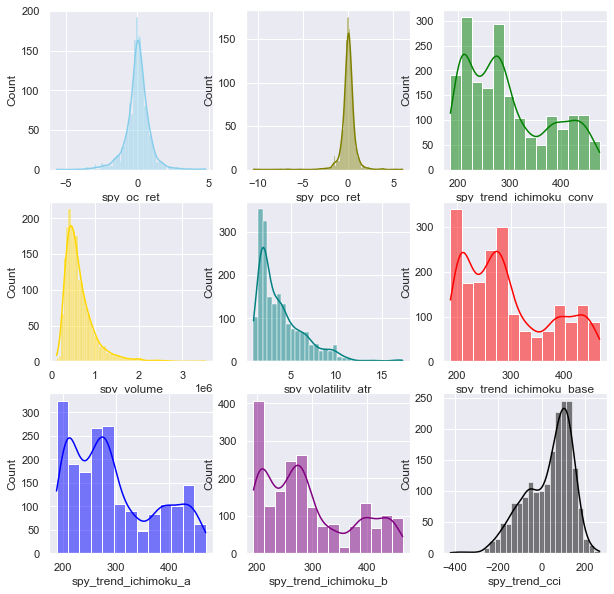

In [58]:
fig, axs = plt.subplots(3, 3, figsize=(10, 10))

sns.histplot(data=df, x=df.columns[0], kde=True, color="skyblue", ax=axs[0, 0])
sns.histplot(data=df, x=df.columns[1], kde=True, color="olive", ax=axs[0, 1])
sns.histplot(data=df, x=df.columns[2], kde=True, color="gold", ax=axs[1, 0])
sns.histplot(data=df, x=df.columns[3], kde=True, color="teal", ax=axs[1, 1])
sns.histplot(data=df, x=df.columns[4], kde=True, color="green", ax=axs[0, 2])
sns.histplot(data=df, x=df.columns[5], kde=True, color="red", ax=axs[1, 2])
sns.histplot(data=df, x=df.columns[6], kde=True, color="blue", ax=axs[2, 0])
sns.histplot(data=df, x=df.columns[7], kde=True, color="purple", ax=axs[2, 1])
sns.histplot(data=df, x=df.columns[8], kde=True, color="black", ax=axs[2, 2])

In [211]:
df1 = df.copy()

In [249]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler


#scaler = MinMaxScaler()
#df1['Chicago_Fed_Fin_Conditions_Index'] = scaler.fit_transform(df['Chicago_Fed_Fin_Conditions_Index'].values.reshape(-1, 1))



#df1['Real_PCE_YoY'] = np.log2(df['Real_PCE_YoY'])
#df1['Initial_Claims'] = np.log2(df['Initial_Claims'])

#df1['US_Real_Disposable_Income'] = np.log2(df['US_Real_Disposable_Income'])


#X['spy_volume'] = np.log2(X['spy_volume'])


#data['logarithm_base2'] = np.log2(data['Salary'])

col = 'US_Personal_Savings_Rate'





#USD_Daily_Return
#Inflation Rate
#10yr minus 2yr yield
#Inversion Signal
#US_Personal_Savings_Rate
#US_Real_Disposable_Income
#M2_and_Components
#Job_Openings_Total_Nonfarm
#St_Louis_Fed_Fin_Stress_Index
#Chicago_Fed_Fin_Conditions_Index



<AxesSubplot:xlabel='US_Personal_Savings_Rate', ylabel='Count'>

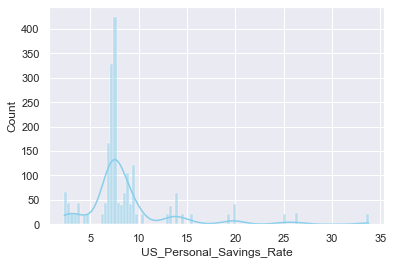

In [250]:


sns.histplot(data=df, x=df[col], kde=True, color="skyblue")

<AxesSubplot:xlabel='US_Personal_Savings_Rate', ylabel='Count'>

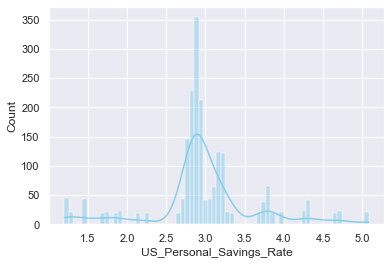

In [251]:
sns.histplot(data=df1, x=df1[col], kde=True, color="skyblue")

<AxesSubplot:xlabel='spy_volume', ylabel='Count'>

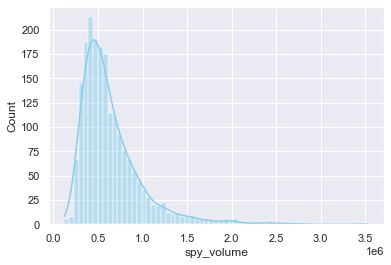

In [159]:
sns.histplot(data=df, x=df.columns[2], kde=True, color="skyblue")

<AxesSubplot:xlabel='spy_volume', ylabel='Count'>

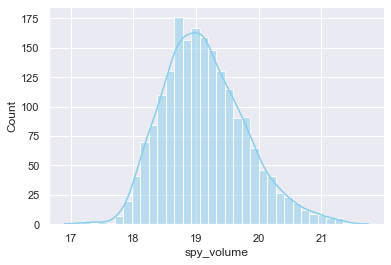

In [141]:
sns.histplot(data=df1, x=df1.columns[2], kde=True, color="skyblue")

<AxesSubplot:xlabel='spy_oc_ret', ylabel='Count'>

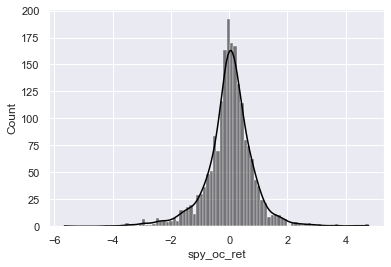

In [142]:
sns.histplot(data=df, x=df.columns[0], kde=True, color="black")

<AxesSubplot:xlabel='target_2', ylabel='Count'>

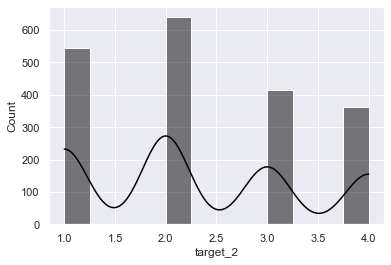

In [168]:
sns.histplot(data=df, x=df.columns[137], kde=True, color="black")

NameError: name 'spy_volatility_atr' is not defined

In [ ]:

'''
spy_oc_ret
spy_pco_ret
spy_volume
spy_volatility_atr
spy_trend_ichimoku_conv
spy_trend_ichimoku_base
spy_trend_ichimoku_a
spy_trend_ichimoku_b
spy_trend_cci
spy_momentum_rsi
spy_trend_macd
spy_trend_macd_signal
spy_momentum_ppo
spy_momentum_ppo_signal
spy_bull
spy_bear
spy_neutral
trade_date
vix_oc_ret
vix_pco_ret
vix_prev_close
vix_prev_open
vix_close
vix_bull
vix_bear
vix_neutral
jnk_oc_ret
jnk_pco_ret
jnk_prev_close
jnk_prev_open
jnk_close
jnk_bull
jnk_bear
jnk_neutral
hyg_oc_ret
hyg_pco_ret
hyg_prev_close
hyg_prev_open
hyg_close
hyg_bull
hyg_bear
hyg_neutral
xle_oc_ret
xle_pco_ret
xle_prev_close
xle_prev_open
xle_close
xle_bull
xle_bear
xle_neutral
xlf_oc_ret
xlf_pco_ret
xlf_prev_close
xlf_prev_open
xlf_close
xlf_bull
xlf_bear
xlf_neutral
xlk_oc_ret
xlk_pco_ret
xlk_prev_close
xlk_prev_open
xlk_close
xlk_bull
xlk_bear
xlk_neutral
xlu_oc_ret
xlu_pco_ret
xlu_prev_close
xlu_prev_open
xlu_close
xlu_bull
xlu_bear
xlu_neutral
xlv_oc_ret
xlv_pco_ret
xlv_prev_close
xlv_prev_open
xlv_close
xlv_bull
xlv_bear
xlv_neutral
xli_oc_ret
xli_pco_ret
xli_prev_close
xli_prev_open
xli_close
xli_bull
xli_bear
xli_neutral
dia_oc_ret
dia_pco_ret
dia_prev_close
dia_prev_open
dia_close
dia_bull
dia_bear
dia_neutral
gld_oc_ret
gld_pco_ret
gld_prev_close
gld_prev_open
gld_close
gld_bull
gld_bear
gld_neutral
datecol
week
year
month
Real_PCE
Real_PCE_YoY
Initial_Claims
Initial_Claims_YoY
USD_Daily_Return
Inflation Rate
10yr minus 2yr yield
Inversion Signal
US_Personal_Savings_Rate
US_Real_Disposable_Income
M2_and_Components
Job_Openings_Total_Nonfarm
St_Louis_Fed_Fin_Stress_Index
Chicago_Fed_Fin_Conditions_Index
month1
month2
month3
month4
month5
month6
month7
month8
month9
month10
month11
month12
'''